In [ ]:
# Ignoring warnings
import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Importing libraries
import time
from tqdm import tqdm
import pandas as pd
import numpy as np

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical

2025-03-22 20:25:10.493798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 20:25:10.493952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 20:25:10.808518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Use GPU Facilities.

In [ ]:
# Checking if GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda - Tesla T4


In [ ]:
# Importing multiple datasets
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "/kaggle/input/cremad/AudioWAV/"
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [ ]:
# Creating a CSV file for RAVDESS dataset
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess_df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


In [ ]:
# Creating a CSV file for CREMA dataset
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema_df.head()

,path,sex,emotion
0,/kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav,male,happy
1,/kaggle/input/cremad/AudioWAV/1076_IEO_FEA_HI.wav,female,fear
2,/kaggle/input/cremad/AudioWAV/1056_IEO_ANG_HI.wav,female,angry
3,/kaggle/input/cremad/AudioWAV/1038_IEO_SAD_HI.wav,male,sad
4,/kaggle/input/cremad/AudioWAV/1043_IEO_DIS_HI.wav,female,disgust


In [ ]:
# Creating a CSV file for TESS dataset
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust'  : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female')
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess_df.head()

,path,sex,emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear


In [ ]:
# Creating a CSV file for SAVEE dataset
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male')
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee_df.head()

,path,sex,emotion
0,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
1,/kaggle/input/surrey-audiovisual-expressed-emo...,male,fear
2,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
3,/kaggle/input/surrey-audiovisual-expressed-emo...,male,disgust
4,/kaggle/input/surrey-audiovisual-expressed-emo...,male,angry


In [ ]:
# Concatinating all the datasets
df = pd.concat([
    ravdess_df, 
    crema_df, 
    tess_df, 
    savee_df
], axis=0)
df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


In [ ]:
# Final shape of the dataset
df.shape

(4331, 3)

Split into training data and test data.

In [ ]:
# Splitting data into training and testing
train_df = df.sample(frac=0.8)
test_df = df.drop(train_df.index)

In [ ]:
# Training sample
train_df.shape

(3465, 3)

In [ ]:
# Testing sample
test_df.shape

(319, 3)

Let's have a look at the training data.

### 2.2 Tokenization

In [ ]:
# Importing pre-trained embeddings from Wav2Vec model
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

# Encoding the audio files to numbers
train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/3465 [00:00<?, ? examples/s]

Map:   0%|          | 0/319 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [ ]:
# Checking for dataset imbalance
train_df.emotion.value_counts()

emotion
fear       599
happy      598
disgust    595
sad        592
angry      589
neutral    492
Name: count, dtype: int64

In [ ]:
# Encoding the labels and creating the dataset
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {
            'neutral': 0,
            'happy': 1,
            'sad': 2,
            'angry': 3,
            'fear': 4,
            'disgust': 5
        }
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, list(train_data["emotion"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["emotion"]))


## 3. Loading the Model and Optimizer 

In [ ]:
# Import pre-trained Hubert model from huggingface
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading pre-trained model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")

# Setting the labels to 6 as model is trained on 4
model.config.num_labels = 6

# Updating classifier to match new number of labels
model.classifier = torch.nn.Linear(model.classifier.in_features, 6)
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametri

## 4. Training

Prepare some utility functions.

In [ ]:
# Checking unique labels in the training and test data
print(set(train_data["emotion"]))
print(set(test_data["emotion"]))

{'neutral', 'disgust', 'fear', 'happy', 'angry', 'sad'}
{'neutral', 'disgust', 'fear', 'happy', 'angry', 'sad'}


In [31]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [ ]:
# Checking number of labels
print(model.config.num_labels)

6


In [ ]:
# Training the model

from torch.utils.data import DataLoader

# Setting the number of epoch
epoch = 10
# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/10


100%|██████████| 1733/1733 [18:56<00:00,  1.52it/s, Loss=2.025, Accuracy=0.637]


Epoch 2/10


100%|██████████| 1733/1733 [18:51<00:00,  1.53it/s, Loss=0.039, Accuracy=0.854]


Epoch 3/10


100%|██████████| 1733/1733 [18:53<00:00,  1.53it/s, Loss=0.096, Accuracy=0.896]


Epoch 4/10


100%|██████████| 1733/1733 [18:49<00:00,  1.53it/s, Loss=0.087, Accuracy=0.915]


Epoch 5/10


100%|██████████| 1733/1733 [18:53<00:00,  1.53it/s, Loss=0.000, Accuracy=0.931]


Epoch 6/10


100%|██████████| 1733/1733 [18:50<00:00,  1.53it/s, Loss=0.000, Accuracy=0.940]


Epoch 7/10


100%|██████████| 1733/1733 [18:53<00:00,  1.53it/s, Loss=0.000, Accuracy=0.949]


Epoch 8/10


100%|██████████| 1733/1733 [18:50<00:00,  1.53it/s, Loss=0.016, Accuracy=0.957]


Epoch 9/10


100%|██████████| 1733/1733 [18:51<00:00,  1.53it/s, Loss=0.000, Accuracy=0.960]


Epoch 10/10


100%|██████████| 1733/1733 [18:50<00:00,  1.53it/s, Loss=0.000, Accuracy=0.970]


In [ ]:
# Saving the models weight
torch.save(model.state_dict(), '/kaggle/working/model_final_epoch.pth')

In [ ]:
# Getting the trained model info
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)
print("labels shape:", labels.shape)

input_ids shape: torch.Size([1, 114220])
attention_mask shape: torch.Size([1, 114220])
labels shape: torch.Size([1])


Visualise the training loss and accuracy.

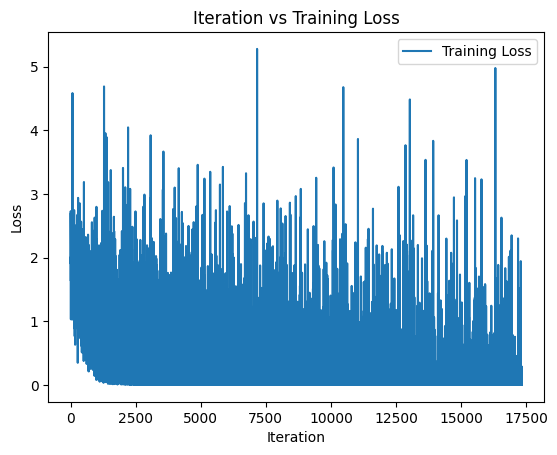

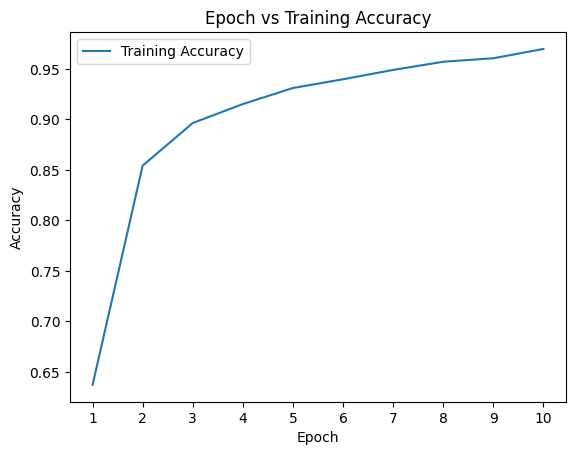

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plotting Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

Test the model.

In [ ]:
# Testing the model
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 319/319 [00:25<00:00, 12.75it/s, loss=0.000, accuracy=0.994]


The final accuracy on the test dataset: 99.373%


Check the result.

In [ ]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show incorrect predictions 
df[df["emotion"]!=df["Model Prediction"]]

,index,path,sex,emotion,Model Prediction
0,482,/kaggle/input/ravdess-emotional-speech-audio/a...,female,ang,LABEL_3
1,508,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fea,LABEL_4
2,530,/kaggle/input/ravdess-emotional-speech-audio/a...,male,ang,LABEL_3
3,548,/kaggle/input/ravdess-emotional-speech-audio/a...,male,sad,LABEL_2
4,558,/kaggle/input/ravdess-emotional-speech-audio/a...,male,dis,LABEL_5
...,...,...,...,...,...
314,2373,/kaggle/input/toronto-emotional-speech-set-tes...,female,sad,LABEL_2
315,2374,/kaggle/input/toronto-emotional-speech-set-tes...,female,sad,LABEL_2
316,2378,/kaggle/input/toronto-emotional-speech-set-tes...,female,sad,LABEL_2
317,2386,/kaggle/input/toronto-emotional-speech-set-tes...,female,sad,LABEL_2


Display the Confusion Matrix of the result.

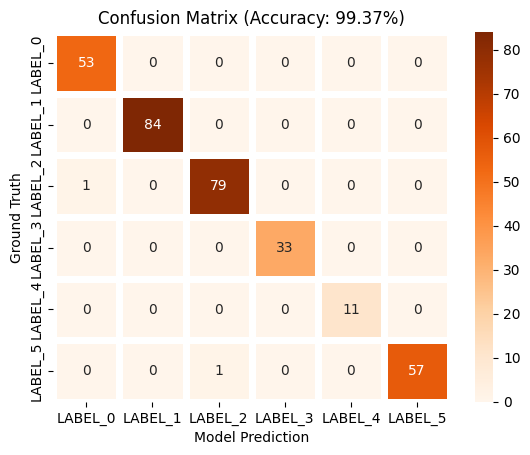

In [40]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()